# Summary Statistics

Summary statistics in genetics capture how each genetic variant relates to a trait, where $\hat{\beta}$ for a SNP is a **noisy measurement** of the association between $X$ and $Y$, representing the primary **data input** for most post-GWAS analyses, allowing researchers to share these standardized $X$-$Y$ relationship measurements instead of raw genotype and phenotype data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide10.png)

# Key Formula

Summary statistics provide standardized measurements that can be shared and combined across studies. The Z-score transforms each variant's association measurement into a comparable format:

$$
Z = \frac{\hat{\beta}}{\text{SE}(\hat{\beta})}
$$

This standardization enables researchers to integrate data across different studies, populations, and analysis methods in downstream applications.


# Technical Details

## From OLS to Summary Statistics

When we perform GWAS analysis using OLS regression on standardized data ($\mathbf{X}$ and $\mathbf{Y}$ scaled to mean 0 and variance 1), we obtain:

$$
\hat{\beta}_j = \frac{\mathbf{X}_j^T \mathbf{Y}}{\mathbf{X}_j^T \mathbf{X}_j} = \mathbf{X}_j^T \mathbf{Y} = \text{Cov}(\mathbf{X}_j, \mathbf{Y}) = r_{\mathbf{X_j}, \mathbf{Y}} 
$$

$$
\text{Var}(\hat{\beta}_j) = \frac{\sigma^2}{\mathbf{X}_j^T \mathbf{X}_j} = \sigma^2
$$

These become the building blocks for many subsequent analyses. The $\hat{\beta}$ values from marginal or joint analysis serve as input measurements for methods like fine-mapping, polygenic risk scores, and Mendelian randomization.

## Standardized Measurements for Analysis

**Z-score:** The standardized measurement that enables cross-study comparison:

$$
Z_j = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j}{\sigma}
$$

**P-value:** Statistical significance of each measurement:

$$
P = 2 \times (1 - \Phi(|Z|))
$$

Where $\Phi$ is the cumulative distribution function of the standard normal distribution.

## Standard GWAS Data Format

| SNP (rsID) | CHR | BP    | A1  | A2  | MAF  | BETA  | SE    | Z-score | P-value  | N     |
|------------|-----|-------|-----|-----|------|-------|-------|---------|----------|-------|
| rs12345    | 1   | 10583 | A   | G   | 0.12 | 0.045 | 0.010 | 4.50    | 1.2e-06  | 100000 |
| rs67890    | 2   | 20345 | C   | T   | 0.35 | -0.030 | 0.008 | -3.75   | 5.4e-04  | 95000  |
| rs54321    | 18   | 45678 | G   | A   | 0.22 | 0.060 | 0.012 | 5.00    | 2.1e-07  | 102000 |

This tabular format provides the essential data inputs that downstream methods require:

**Data Fields:**
- **SNP (rsID)**: Variant identifier for matching across datasets
- **CHR/BP**: Genomic coordinates for positional analysis  
- **A1/A2**: Allele definitions for effect direction consistency
- **MAF/EAF**: Allele frequencies for population matching and quality control
- **BETA/SE**: The core association measurements with uncertainty quantification
- **Z-score/P-value**: Standardized significance measures for prioritization
- **N**: Sample size for meta-analysis weighting

## Frequentist vs Bayesian Perspectives

The formulation above represents the **frequentist view**, where $\hat{\beta}_j$ is a point estimate with associated uncertainty $\text{SE}(\hat{\beta}_j)$.

In the **Bayesian framework**, we start with the hierarchical model:

$$
\mathbf{Y} = \mathbf{X}\beta + \boldsymbol{\epsilon}
$$

$$
\hat{\beta}_j \sim N(\beta_j, \sigma^2)
$$

Here, $\hat{\beta}_j$ is treated as a noisy observation of the true parameter $\beta_j$ and the **noise** comes from the assumption that it comes from a distribution rather than a fixed value. This allows Bayesian methods to quantify the uncertainty and place informative priors on effect sizes.

*Note: Don't worry if this Bayesian perspective seems abstract right now. We recommend revisiting this section after reading through the topics in the Related Topics section, which will provide concrete examples of how this framework is applied in practice.*

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [odds ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)
- [mediator](https://statfungen.github.io/statgen-primer/mediator.html)
- [confounder](https://statfungen.github.io/statgen-primer/confounder.html)
- [marginal/joint effects model](https://statfungen.github.io/statgen-primer/marginal_joint_effects.html)
- [random effect](https://statfungen.github.io/statgen-primer/random_effect.html)
- [Bayesian normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_normal_mean_model.html)


# Example

In [1]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5
M = 3
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}

X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

Let's initialize the summary statistics.

In [2]:
# Initialize summary statistics data frame
# Calculate minor allele frequencies
MAF <- colMeans(Xraw_additive) / 2
ref_alleles <- c("C", "T", "A")

sumstats_0 <- data.frame(
  SNP = paste0("rs", 1:M),
  CHR = c(1, 1, 2),  # Example chromosome assignments
  BP = c(1315, 2620, 6290),  # Example base pair positions
  ALT = alt_alleles,  # Effect allele
  REF = ref_alleles,  # Reference allele
  EAF = MAF,  # Effect allele frequency
  N = rep(N, M),  # Sample size
  BETA = numeric(M),  # Effect size
  SE = numeric(M),  # Standard error
  Z = numeric(M),  # Z-score
  P = numeric(M)  # P-value
)

## Example 1: Summary Statistics using Linear and Logistic Models

In this example, we simulate a simple genome-wide association study (GWAS) by testing the relationship between three genetic variants and trait across five individuals.

### Continuous Outcome -- Height

Let's first use OLS to compute the summary statistics for a continuous variable --- height (we have done this in [Lecture: ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)).

In [3]:
# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

We perform ordinary least square analysis on each single SNP using `lm` function in R:

In [4]:
p_values <- numeric(M)  # Store p-values
betas <- numeric(M)     # Store estimated effect sizes
sumstats_height <- sumstats_0  # Initialize summary statistics data frame for height
for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  # Store results in standard format
  sumstats_height$BETA[j] <- summary_model$coefficients[2, 1]  # Effect size
  sumstats_height$SE[j] <- summary_model$coefficients[2, 2]    # Standard error
  sumstats_height$Z[j] <- summary_model$coefficients[2, 3]     # t-statistic (equivalent to Z-score)
  sumstats_height$P[j] <- summary_model$coefficients[2, 4]     # P-value
}


The summary statistics results are:

In [5]:
sumstats_height

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,-0.5000913,0.49996955,-1.000244,0.390901513
Variant 2,rs2,1,2620,C,T,0.4,5,0.8525024,0.30179448,2.824778,0.066475513
Variant 3,rs3,2,6290,T,A,0.3,5,0.9866667,0.09396605,10.500246,0.001844466


### Binary Outcome --- Disease Status

Let's then use logistic regression to compute the summary statistics for a binary trait --- disease status (we have done this in [Lecture: odds_ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)).

In [6]:
# assign observed disease status for the 5 individuals
Y_binary <- c(1, 0, 0, 0, 1)

In [7]:
sumstats_binary <- sumstats_0
# Perform GWAS analysis: Test each SNP independently using logistic regression
for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- glm(Y_binary ~ SNP, family = binomial(link = "logit"))  # Logistic regression: Binary trait ~ SNP
  summary_model <- summary(model)
  
  # Store results in standard format
  sumstats_binary$BETA[j] <- summary_model$coefficients[2, 1]  # Log odds ratio (effect size)
  sumstats_binary$SE[j] <- summary_model$coefficients[2, 2]    # Standard error
  sumstats_binary$Z[j] <- summary_model$coefficients[2, 3]     # z-statistic
  sumstats_binary$P[j] <- summary_model$coefficients[2, 4]     # P-value
}


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


GWAS Summary Statistics based on our toy data would be:

In [8]:
sumstats_binary

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,-17.68860,7555.904,-0.0023410307,0.9981321
Variant 2,rs2,1,2620,C,T,0.4,5,17.20681,8564.582,0.0020090656,0.9983970
Variant 3,rs3,2,6290,T,A,0.3,5,41.95806,72333.584,0.0005800633,0.9995372


Note that the SE is extremely large because the sample size in our toy data is too small (5).

## Example 2: Summary Statistics When Considering Covariates

For this example we assume you already understand the basics of summary statistics and the concepts of covariates.

We calculate the summary statistics using OLS and consider age as the covariate.

In [9]:
sumstats_age <- sumstats_0

# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

# Add age as a covariate
age <- c(65, 45, 38, 52, 71)  # Example ages for the 5 individuals

# Standardize age for better numerical stability
age_scaled <- scale(age, center=TRUE, scale=TRUE)[,1]

# Perform GWAS analysis with age as covariate: Test each SNP independently using linear regression
for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP + age_scaled) 
  summary_model <- summary(model)
  
  # Store results in standard format (coefficients for SNP, not age)
  sumstats_age$BETA[j] <- summary_model$coefficients[2, 1]  # Log odds ratio for SNP (effect size)
  sumstats_age$SE[j] <- summary_model$coefficients[2, 2]    # Standard error for SNP
  sumstats_age$Z[j] <- summary_model$coefficients[2, 3]     # z-statistic for SNP
  sumstats_age$P[j] <- summary_model$coefficients[2, 4]     # P-value for SNP
}

Recall that when we didn't consider age and the summary statistics is:

In [10]:
sumstats_height

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,-0.5000913,0.49996955,-1.000244,0.390901513
Variant 2,rs2,1,2620,C,T,0.4,5,0.8525024,0.30179448,2.824778,0.066475513
Variant 3,rs3,2,6290,T,A,0.3,5,0.9866667,0.09396605,10.500246,0.001844466


When we add age as the covariates, the results are different from above:

In [11]:
sumstats_age

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,0.2661395,0.3977629,0.6690908,0.57233126
Variant 2,rs2,1,2620,C,T,0.4,5,0.4832254,0.1987531,2.4312852,0.13559721
Variant 3,rs3,2,6290,T,A,0.3,5,0.9671826,0.2712268,3.5659554,0.07043351


## Example 3: Marginal and Joint Effects

In Example 1 and 2, we always consider each variant independently (using the `for` loop) and treat them one by one. The summary statistics, therefore, describes the marginal effect of each variant on the trait value.

However, this ignores the LD between the variants. And when multiple variants are considered in a single model at the same time, we can obtain the joint effects.  

In [12]:
sumstats_joint <- sumstats_0

# Assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

In [13]:
# JOINT EFFECTS: Test all SNPs together in one model
model_joint <- lm(Y ~ X[,1] + X[,2] + X[,3])  # All SNPs in one model
summary_joint <- summary(model_joint)

# Store joint results for each SNP
for (j in 1:M) {
  sumstats_joint$BETA[j] <- summary_joint$coefficients[j+1, 1]  # Effect size (j+1 because intercept is position 1)
  sumstats_joint$SE[j] <- summary_joint$coefficients[j+1, 2]    # Standard error
  sumstats_joint$Z[j] <- summary_joint$coefficients[j+1, 3]     # t-statistic
  sumstats_joint$P[j] <- summary_joint$coefficients[j+1, 4]     # P-value
}

Recall again the marginal effects of the three variants:

In [14]:
sumstats_height

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,-0.5000913,0.49996955,-1.000244,0.390901513
Variant 2,rs2,1,2620,C,T,0.4,5,0.8525024,0.30179448,2.824778,0.066475513
Variant 3,rs3,2,6290,T,A,0.3,5,0.9866667,0.09396605,10.500246,0.001844466


The joint effect results are:

In [15]:
sumstats_joint

,SNP,CHR,BP,ALT,REF,EAF,N,BETA,SE,Z,P
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,rs1,1,1315,T,C,0.3,5,0.08109589,0.1793098,0.45226702,0.7296037
Variant 2,rs2,1,2620,C,T,0.4,5,-0.02528609,0.2991890,-0.08451543,0.9463234
Variant 3,rs3,2,6290,T,A,0.3,5,1.05424659,0.3198465,3.29610159,0.1875245


# Supplementary

## Graphical Summary

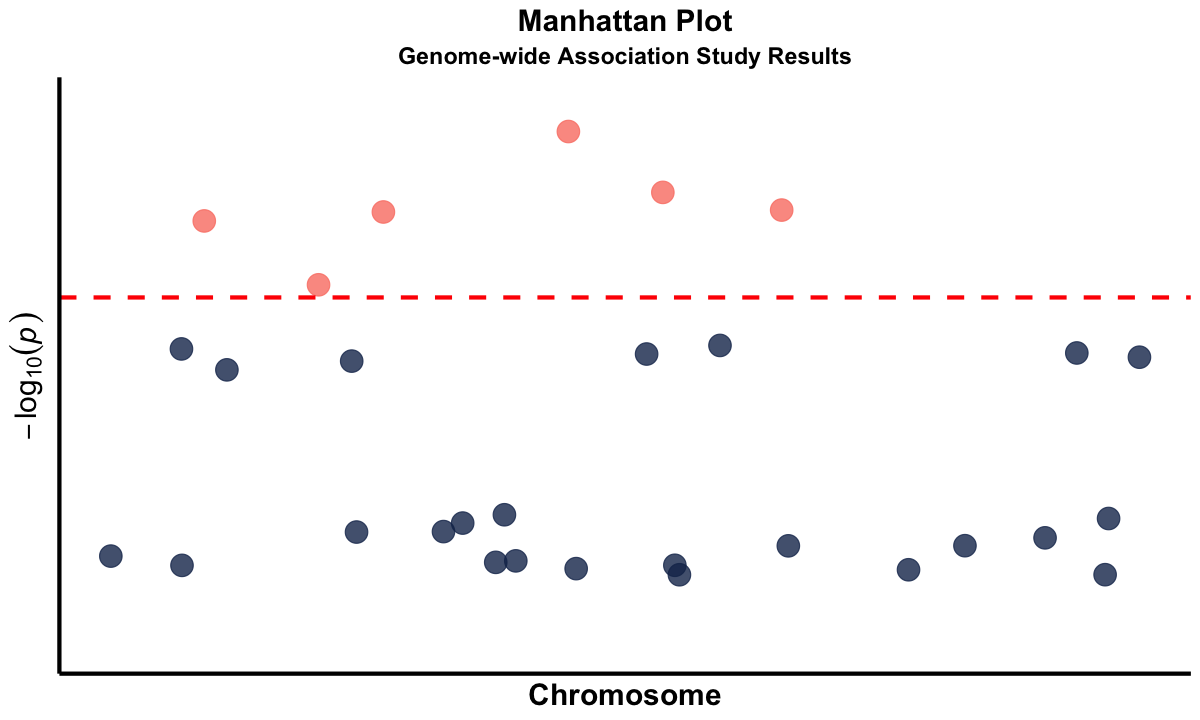

In [16]:
library(ggplot2)
suppressPackageStartupMessages(library(dplyr))

# Set plot dimensions
options(repr.plot.width = 10, repr.plot.height = 6)

# Set seed for reproducibility
set.seed(123)

# Generate simulated GWAS data for ~30 SNPs
n_snps <- 30
gwas_data <- data.frame(
  SNP = paste0("rs", sample(1000000:9999999, n_snps)),
  CHR = sample(1:22, n_snps, replace = TRUE),
  BP = sample(1000000:250000000, n_snps),
  P = c(
    # Add some significant hits
    runif(5, 1e-8, 1e-6),
    # Add some suggestive hits  
    runif(8, 1e-6, 1e-4),
    # Add the rest as non-significant
    runif(17, 1e-4, 0.05)
  )
)

# Calculate -log10(P) values
gwas_data$logP <- -log10(gwas_data$P)

# Sort by chromosome and position
gwas_data <- gwas_data %>% 
  arrange(CHR, BP)

# Create cumulative position for x-axis
gwas_data <- gwas_data %>%
  group_by(CHR) %>%
  summarise(chr_len = max(BP)) %>%
  mutate(tot = cumsum(as.numeric(chr_len)) - chr_len) %>%
  select(-chr_len) %>%
  left_join(gwas_data, ., by = c("CHR" = "CHR")) %>%
  arrange(CHR, BP) %>%
  mutate(BPcum = BP + tot)

# Prepare x-axis labels
axisdf <- gwas_data %>% 
  group_by(CHR) %>% 
  summarize(center = (max(BPcum) + min(BPcum)) / 2)

# Create the Manhattan plot
manhattan_plot <- ggplot(gwas_data, aes(x = BPcum, y = logP)) +
  # Add points - salmon for points above the red line, dark blue for others
  geom_point(aes(color = ifelse(logP > -log10(1e-5), "significant", "non_significant")), 
             alpha = 0.8, size = 6) +
  
  # Customize colors
  scale_color_manual(values = c("significant" = "salmon", "non_significant" = "#183059")) +
  
  # Add significance line (blue line position but red color)
  geom_hline(yintercept = -log10(1e-5), color = "red", linetype = "dashed", linewidth = 1.2) +
  
  # Customize x-axis (remove axis text)
  scale_x_continuous(labels = NULL) +
  
  # Customize y-axis (remove axis text)
  scale_y_continuous(expand = c(0, 0), limits = c(0, max(gwas_data$logP) * 1.1), labels = NULL) +
  
  # Labels and theme
  labs(
    title = "Manhattan Plot",
    subtitle = "Genome-wide Association Study Results",
    x = "Chromosome", 
    y = expression(-log[10](italic(p)))
  ) +
  
  # Clean theme with larger, bold fonts, thicker axes, and transparent background
  theme_classic() +
  theme(
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(colour = "black", linewidth = 1.2),
    axis.ticks = element_line(linewidth = 1.2),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(size = 14, hjust = 0.5, face = "bold"),
    axis.title = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 18, face = "bold"),
    plot.background = element_rect(fill = "transparent", color = NA),
    panel.background = element_rect(fill = "transparent", color = NA)
  )

# Display the plot
print(manhattan_plot)

# Save the figure
ggsave("./cartoons/summary_statistics.png", plot = manhattan_plot, 
       width = 10, height = 6, dpi = 300, bg = "transparent")